# Predicción de Demanda de Transporte

## Dataset generado

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import random

# Configuración para reproducibilidad
np.random.seed(42)
random.seed(42)

# Parámetros del dataset
n_samples = 500000  # 500,000 registros históricos
locations = ['Taj Mahal', 'Goa Beaches', 'Jaipur City', 'Kerala Backwaters', 'Leh Ladakh']
vehicle_types = ['luxury_bus', 'standard_bus', 'minibus', 'van']
payment_methods = ['cash', 'mobile_payment', 'credit_card', 'travel_card']
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = (end_date - start_date).days

# Variables meteorológicas
weather_conditions = ['sunny', 'rainy', 'cloudy', 'foggy', 'stormy']

# Generar datos con patrones estacionales (actualizado según tus indicaciones)
def generate_demand_pattern(date, location):
    """Genera patrones de demanda basados en temporada, día de semana y ubicación"""
    day_of_week = date.weekday()
    month = date.month
    is_weekend = day_of_week >= 5
    is_holiday = random.random() < 0.05  # 5% de probabilidad de ser día festivo
    
    # Factores base por ubicación (con temporadas actualizadas)
    if location == 'Taj Mahal':
        base = 50
        # Alta temporada: Nov-Feb (como solicitaste)
        season_factor = 1.6 if month in [11,12,1,2] else 1.0
    elif location == 'Goa Beaches':
        base = 40
        # Alta temporada: Nov-Mar (como solicitaste)
        season_factor = 1.8 if month in [11,12,1,2,3] else 0.7 if month in [6,7,8,9] else 1.0
    elif location == 'Jaipur City':
        base = 35
        # Alta temporada: Oct-Mar (como solicitaste)
        season_factor = 1.5 if month in [10,11,12,1,2,3] else 1.0
    elif location == 'Kerala Backwaters':
        base = 30
        # Alta temporada: Sep-Mar (como solicitaste)
        season_factor = 1.7 if month in [9,10,11,12,1,2,3] else 0.8
    elif location == 'Leh Ladakh':
        base = 25
        # Temporada accesible: Apr-Jun (como solicitaste)
        season_factor = 1.5 if month in [4,5,6] else 0.1
    
    # Factores por día
    weekend_factor = 1.3 if is_weekend else 1.0
    holiday_factor = 1.5 if is_holiday else 1.0
    
    # Variación aleatoria
    random_factor = np.random.normal(1, 0.1)
    
    return int(base * season_factor * weekend_factor * holiday_factor * random_factor)

# Generar datos
ride_ids = np.arange(1, n_samples + 1)
travel_dates = [start_date + timedelta(days=np.random.randint(0, date_range)) for _ in range(n_samples)]
travel_times = [datetime(2020, 1, 1, np.random.randint(5, 23), np.random.randint(0, 60)).time() for _ in range(n_samples)]
travel_from = ['Delhi Hub'] * n_samples  # Todos parten desde el hub principal
travel_to = np.random.choice(locations, n_samples, p=[0.3, 0.25, 0.2, 0.15, 0.1])  # Probabilidades diferentes por destino
vehicle_type = np.random.choice(vehicle_types, n_samples, p=[0.2, 0.5, 0.2, 0.1])  # Más buses estándar
max_capacity = np.array([50 if vt == 'luxury_bus' else 45 if vt == 'standard_bus' else 20 if vt == 'minibus' else 12 for vt in vehicle_type])
payment_method = np.random.choice(payment_methods, n_samples, p=[0.3, 0.4, 0.2, 0.1])
weather = np.random.choice(weather_conditions, n_samples, p=[0.6, 0.15, 0.15, 0.05, 0.05])

# Generar número de pasajeros con patrones realistas
passengers = []
for i in range(n_samples):
    date = travel_dates[i]
    location = travel_to[i]
    time = travel_times[i]
    vt = vehicle_type[i]
    w = weather[i]
    
    base_demand = generate_demand_pattern(date, location)
    
    # Ajustar por hora del día (picos mañana y tarde)
    hour = time.hour
    if 7 <= hour < 10:
        time_factor = 1.4
    elif 16 <= hour < 19:
        time_factor = 1.3
    else:
        time_factor = 1.0
    
    # Ajustar por tipo de vehículo
    vehicle_factor = 1.2 if vt in ['luxury_bus', 'standard_bus'] else 1.0
    
    # Ajustar por clima
    weather_factor = 0.5 if w == 'stormy' else 0.8 if w == 'rainy' else 1.0
    
    # Calcular pasajeros finales
    p = int(base_demand * time_factor * vehicle_factor * weather_factor * np.random.normal(1, 0.08))
    p = max(1, min(p, max_capacity[i]))  # Asegurar entre 1 y capacidad máxima
    
    passengers.append(p)

# Variables adicionales
ticket_prices = np.array([800 if to == 'Leh Ladakh' else 500 if to == 'Goa Beaches' else 400 if to == 'Kerala Backwaters' else 300 for to in travel_to])
duration_hours = np.array([12 if to == 'Leh Ladakh' else 8 if to == 'Goa Beaches' else 6 if to == 'Kerala Backwaters' else 4 for to in travel_to])
special_events = np.random.choice([0, 1], n_samples, p=[0.9, 0.1])  # 10% de viajes durante eventos especiales

# Crear DataFrame
data = pd.DataFrame({
    'ride_id': ride_ids,
    'travel_date': travel_dates,
    'travel_time': travel_times,
    'departure_city': travel_from,
    'destination': travel_to,
    'vehicle_type': vehicle_type,
    'max_capacity': max_capacity,
    'actual_passengers': passengers,
    'load_factor': np.array(passengers) / max_capacity,
    'payment_method': payment_method,
    'weather_condition': weather,
    'ticket_price': ticket_prices,
    'duration_hours': duration_hours,
    'special_event': special_events,
    'month': [d.month for d in travel_dates],
    'day_of_week': [d.weekday() for d in travel_dates],
    'is_weekend': [d.weekday() >= 5 for d in travel_dates]
})

# Agregar algunas cancelaciones (5% de los viajes)
canceled = np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
data['canceled'] = canceled
data.loc[data['canceled'] == 1, 'actual_passengers'] = 0
data.loc[data['canceled'] == 1, 'load_factor'] = 0

# Guardar dataset
data.to_csv("transport_demand_dataset.csv", index=False)

# Mostrar las primeras filas
print(data.head())

   ride_id travel_date travel_time departure_city  destination  vehicle_type  \
0        1  2023-01-31    22:05:00      Delhi Hub    Taj Mahal  standard_bus   
1        2  2023-12-30    12:54:00      Delhi Hub    Taj Mahal  standard_bus   
2        3  2022-05-10    17:54:00      Delhi Hub    Taj Mahal       minibus   
3        4  2023-07-18    20:03:00      Delhi Hub  Jaipur City    luxury_bus   
4        5  2023-02-04    10:02:00      Delhi Hub  Goa Beaches    luxury_bus   

   max_capacity  actual_passengers  load_factor  payment_method  \
0            45                 45          1.0            cash   
1            45                 45          1.0  mobile_payment   
2            20                 20          1.0     credit_card   
3            50                  0          0.0  mobile_payment   
4            50                 50          1.0            cash   

  weather_condition  ticket_price  duration_hours  special_event  month  \
0             rainy           300        

## EDA

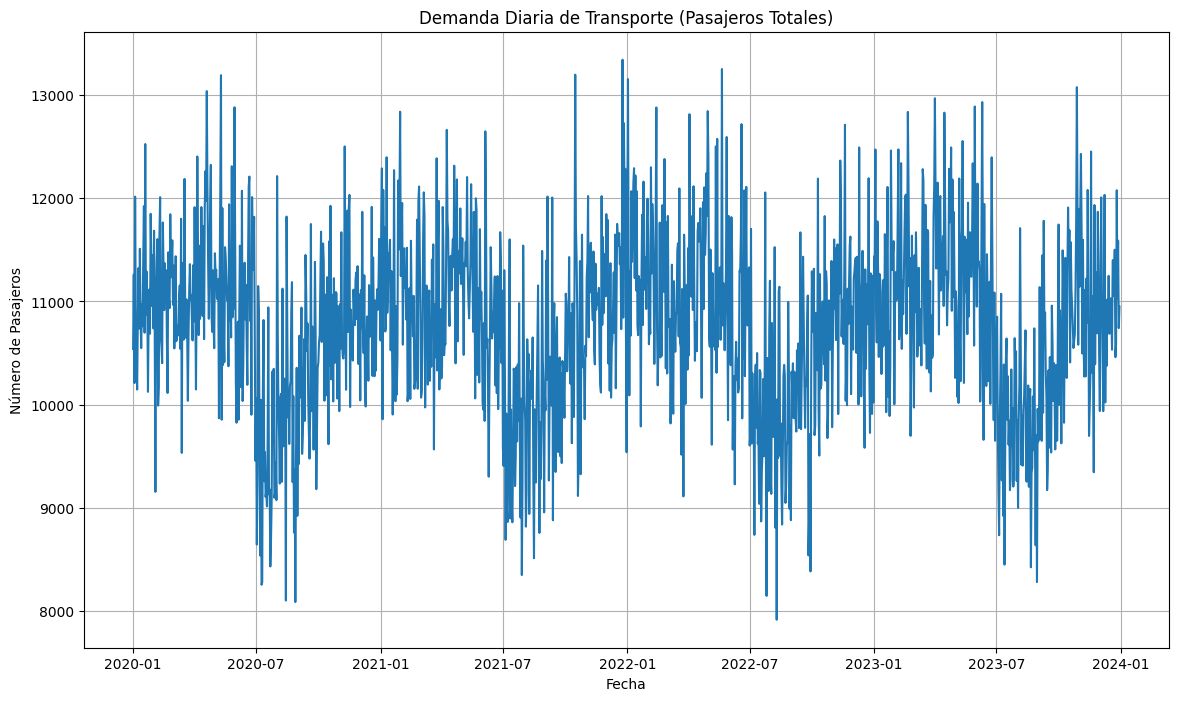

C:\Users\Tomás\AppData\Local\Temp\ipykernel_18824\3125556799.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = daily_data.resample('M').sum()


<Figure size 1400x1000 with 0 Axes>

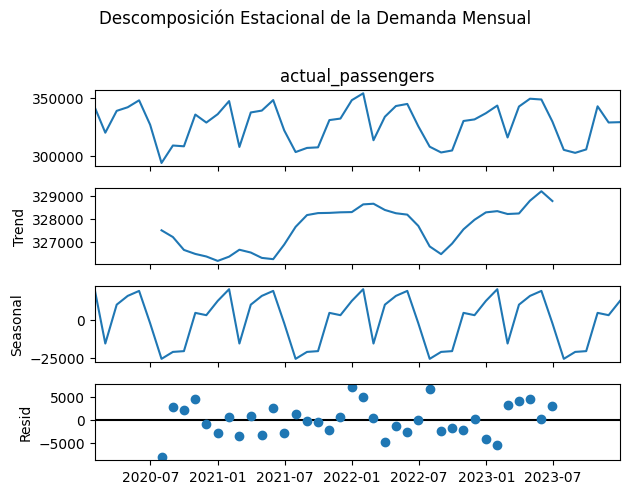

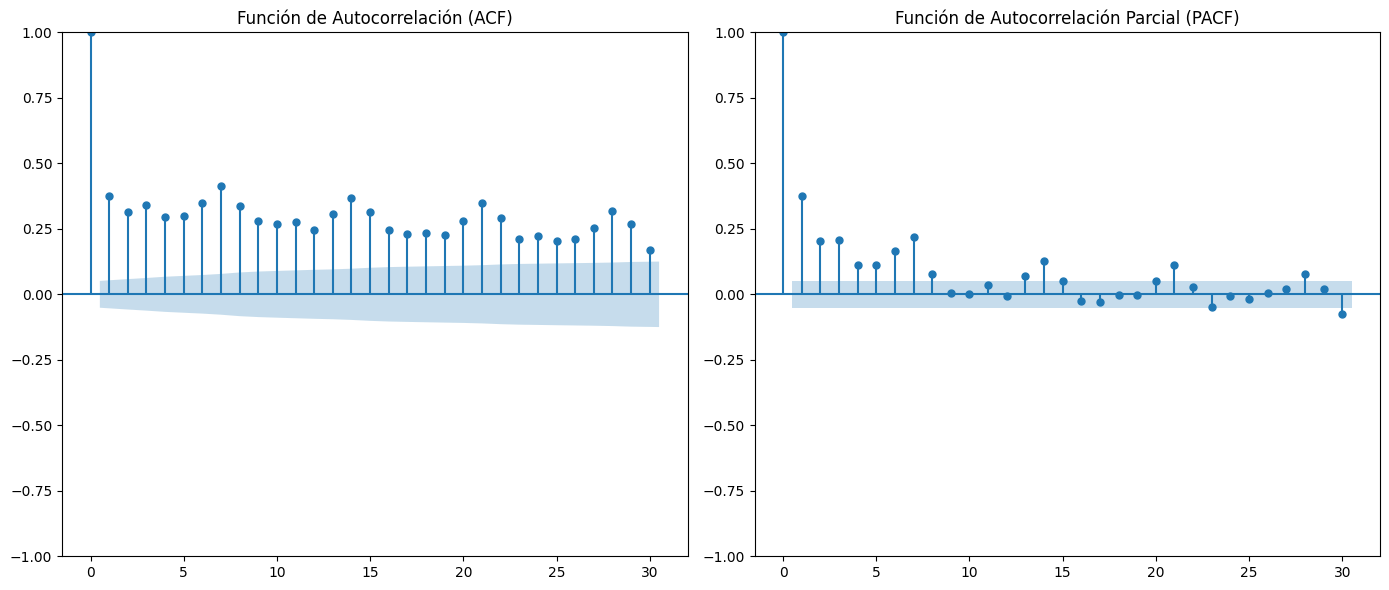

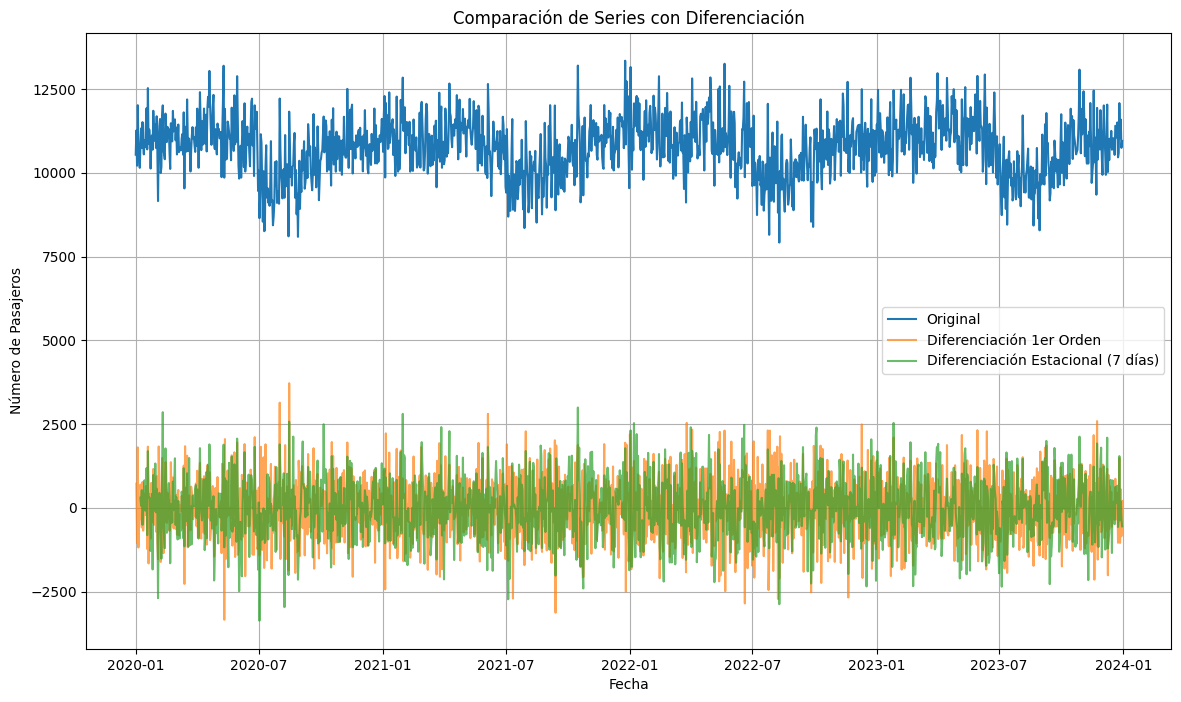

C:\Users\Tomás\AppData\Local\Temp\ipykernel_18824\3125556799.py:87: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  destination_monthly = data.groupby(['destination', pd.Grouper(key='travel_date', freq='M')])['actual_passengers'].sum().unstack(level=0)


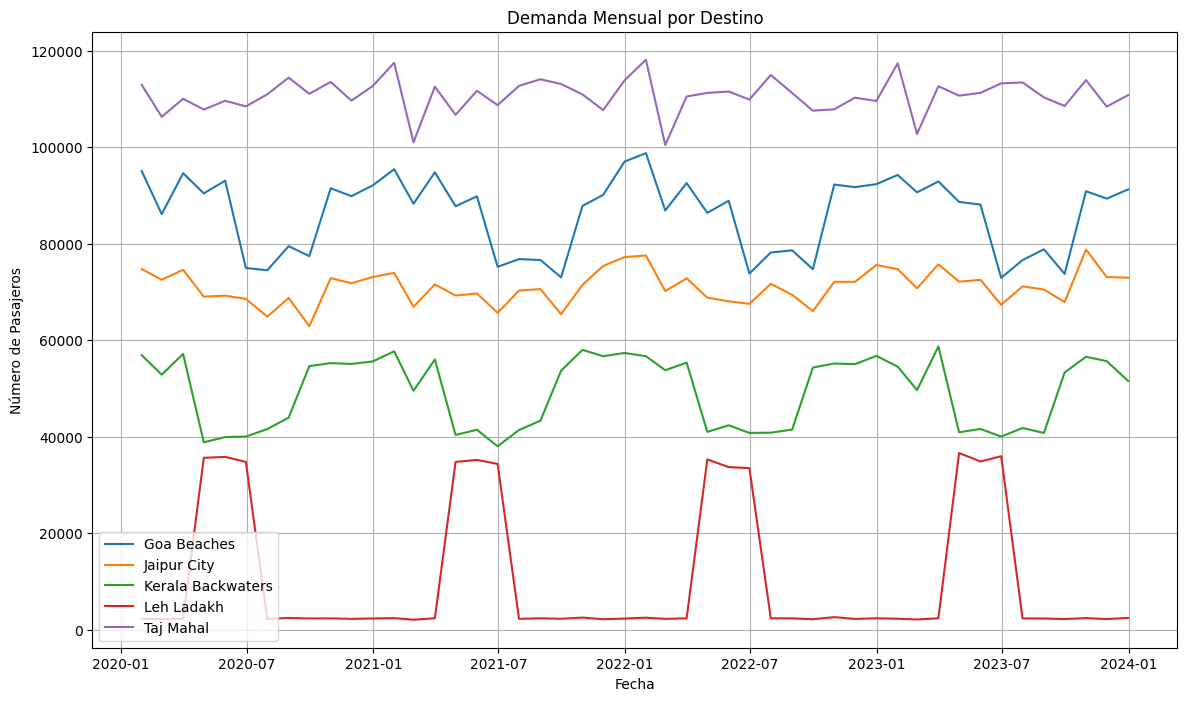

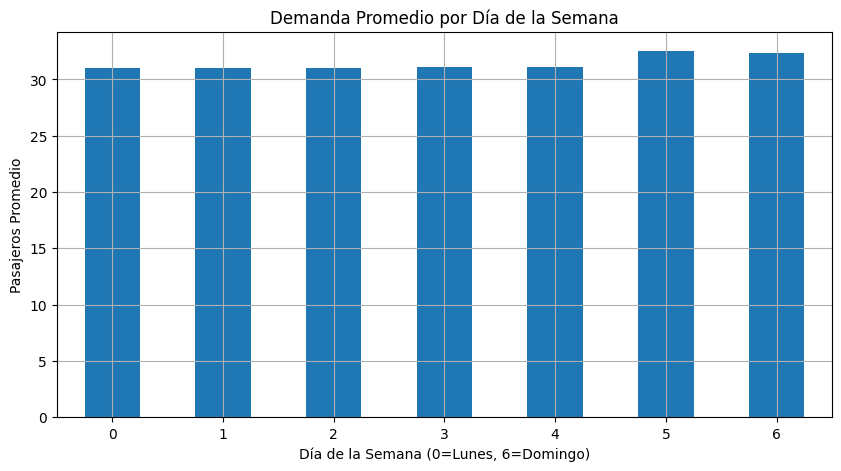

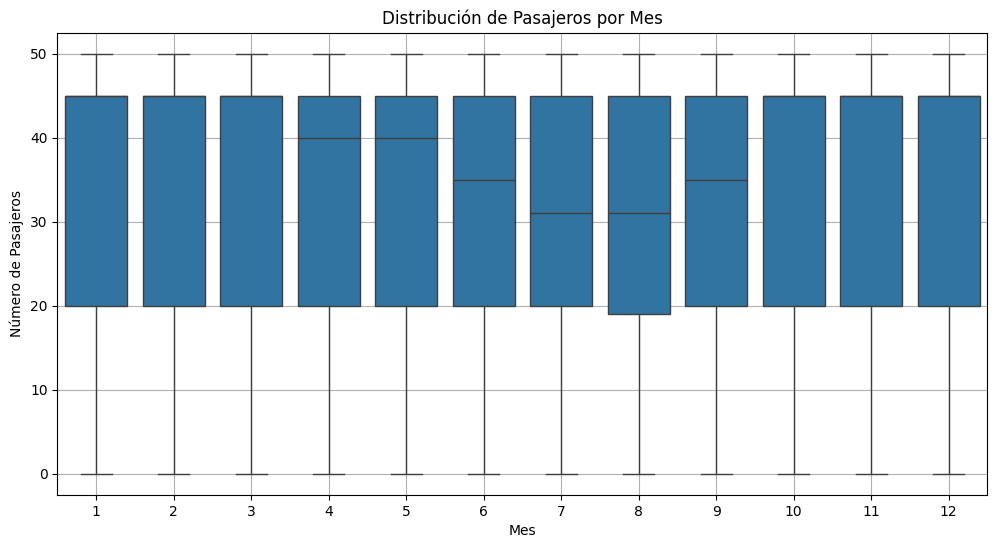

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar datos
data = pd.read_csv("transport_demand_dataset.csv")
data['travel_date'] = pd.to_datetime(data['travel_date'])

# =============================================
# 1. Análisis de la Serie Temporal Global
# =============================================

# Agregar datos por día
daily_data = data.groupby('travel_date').agg({
    'actual_passengers': 'sum',
    'ride_id': 'count'
}).rename(columns={'ride_id': 'num_trips'})

plt.figure(figsize=(14, 8))
plt.plot(daily_data.index, daily_data['actual_passengers'])
plt.title('Demanda Diaria de Transporte (Pasajeros Totales)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.grid(True)
plt.show()

# =============================================
# 2. Descomposición Estacional
# =============================================

# Usaremos datos mensuales para mejor visualización
monthly_data = daily_data.resample('M').sum()

# Descomposición aditiva (Trend + Seasonality + Residual)
decomposition = seasonal_decompose(monthly_data['actual_passengers'], model='additive', period=12)

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Descomposición Estacional de la Demanda Mensual', y=1.02)
plt.tight_layout()
plt.show()

# =============================================
# 3. Autocorrelación y Autocorrelación Parcial
# =============================================

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(daily_data['actual_passengers'], lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(daily_data['actual_passengers'], lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

# =============================================
# 4. Diferenciación Estacional
# =============================================

# Diferenciación simple (primer orden)
daily_data['diff_1'] = daily_data['actual_passengers'].diff()

# Diferenciación estacional (para patrones semanales)
daily_data['diff_seasonal_7'] = daily_data['actual_passengers'].diff(7)

plt.figure(figsize=(14, 8))
plt.plot(daily_data.index, daily_data['actual_passengers'], label='Original')
plt.plot(daily_data.index, daily_data['diff_1'], label='Diferenciación 1er Orden', alpha=0.7)
plt.plot(daily_data.index, daily_data['diff_seasonal_7'], label='Diferenciación Estacional (7 días)', alpha=0.7)
plt.title('Comparación de Series con Diferenciación')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 5. Análisis por Destino
# =============================================

# Agrupar por destino y mes
destination_monthly = data.groupby(['destination', pd.Grouper(key='travel_date', freq='M')])['actual_passengers'].sum().unstack(level=0)

plt.figure(figsize=(14, 8))
for destination in destination_monthly.columns:
    plt.plot(destination_monthly.index, destination_monthly[destination], label=destination)
plt.title('Demanda Mensual por Destino')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 6. Análisis de Estacionalidad Semanal
# =============================================

data['day_of_week'] = data['travel_date'].dt.dayofweek
weekday_avg = data.groupby('day_of_week')['actual_passengers'].mean()

plt.figure(figsize=(10, 5))
weekday_avg.plot(kind='bar')
plt.title('Demanda Promedio por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Pasajeros Promedio')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# =============================================
# 7. Boxplots por Mes (para identificar outliers)
# =============================================

data['month'] = data['travel_date'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='actual_passengers', data=data)
plt.title('Distribución de Pasajeros por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Pasajeros')
plt.grid(True)
plt.show()

## Data Preprocessing

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Cargar los datos (usando el dataset que generamos anteriormente)
data = pd.read_csv("transport_demand_dataset.csv")

# =============================================
# Feature Engineering
# =============================================

# Convertir a datetime y extraer características temporales
data['travel_date'] = pd.to_datetime(data['travel_date'])
data['day_of_week'] = data['travel_date'].dt.dayofweek
data['month'] = data['travel_date'].dt.month
data['year'] = data['travel_date'].dt.year
data['hour'] = pd.to_datetime(data['travel_time']).dt.hour

# Crear variable binaria para temporada alta
def is_high_season(row):
    destination = row['destination']
    month = row['month']
    
    if destination == 'Taj Mahal' and month in [11, 12, 1, 2]:
        return 1
    elif destination == 'Goa Beaches' and month in [11, 12, 1, 2, 3]:
        return 1
    elif destination == 'Jaipur City' and month in [10, 11, 12, 1, 2, 3]:
        return 1
    elif destination == 'Kerala Backwaters' and month in [9, 10, 11, 12, 1, 2, 3]:
        return 1
    elif destination == 'Leh Ladakh' and month in [4, 5, 6]:
        return 1
    else:
        return 0

data['high_season'] = data.apply(is_high_season, axis=1)

# =============================================
# Preprocesamiento
# =============================================

# Definir variables objetivo y features
# Vamos a predecir el número de pasajeros (regresión)
# También podríamos predecir load_factor o binary high_demand
y = data['actual_passengers']

# Eliminar columnas irrelevantes o con información duplicada
X = data.drop(columns=[
    'ride_id', 
    'travel_date', 
    'travel_time',
    'load_factor',  # No usar porque es función directa de actual_passengers
    'canceled',     # No usar en predicción (información del futuro)
    'is_weekend'    # Ya tenemos day_of_week
])

# Definir columnas categóricas y numéricas
categorical_features = [
    'departure_city',
    'destination',
    'vehicle_type',
    'payment_method',
    'weather_condition'
]

numerical_features = [
    'max_capacity',
    'ticket_price',
    'duration_hours',
    'day_of_week',
    'month',
    'year',
    'hour',
    'special_event',
    'high_season'  # Aunque es binaria, la tratamos como numérica
]

# Transformadores para el preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Por si hay valores faltantes
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Por si hay valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar transformadores en un preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# =============================================
# Dividir los datos (train/test split)
# =============================================

# Dividir manteniendo la estructura temporal (últimos meses para test)
sorted_data = data.sort_values('travel_date')
split_date = sorted_data['travel_date'].quantile(0.8)  # 80% train, 20% test

train = sorted_data[sorted_data['travel_date'] < split_date]
test = sorted_data[sorted_data['travel_date'] >= split_date]

X_train = train.drop(columns=['actual_passengers'])
y_train = train['actual_passengers']
X_test = test.drop(columns=['actual_passengers'])
y_test = test['actual_passengers']

# =============================================
# Pipeline completo (para usar con cualquier modelo)
# =============================================

# Pipeline completo que incluye preprocesamiento + modelo
# (Aquí solo mostramos el preprocesamiento, luego se puede añadir el modelo)
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar el preprocesamiento a los datos de entrenamiento
X_train_preprocessed = full_pipeline.fit_transform(X_train)
X_test_preprocessed = full_pipeline.transform(X_test)

# Obtener nombres de las características después del OneHotEncoding
# (Útil para interpretación de modelos)
onehot_columns = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(onehot_columns)

print(f"Forma de los datos preprocesados: {X_train_preprocessed.shape}")
print(f"Nombres de características: {feature_names[:10]}...")  # Mostrar solo las primeras 10

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Escalado final (normalización)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data[['actual_passengers']])

# Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-30):  # 30 días para predicción
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+30])  # Predecir 30 días
    return np.array(X), np.array(y)

SEQ_LENGTH = 90  # Usar 3 meses de histórico
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split temporal (no shuffle!)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

C:\Users\Tomás\AppData\Local\Temp\ipykernel_18824\1848726100.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hour'] = pd.to_datetime(data['travel_time']).dt.hour


Forma de los datos preprocesados: (399656, 28)
Nombres de características: ['max_capacity', 'ticket_price', 'duration_hours', 'day_of_week', 'month', 'year', 'hour', 'special_event', 'high_season', 'departure_city_Delhi Hub']...


## Construcción del Modelo

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, concatenate
from tensorflow.keras.optimizers import Adam

# Arquitectura con Mecanismo de Atención
def build_hybrid_model(seq_length, feature_count):
    # Input para serie temporal
    ts_input = Input(shape=(seq_length, feature_count))
    
    # Capa LSTM
    lstm_layer = LSTM(128, return_sequences=True)(ts_input)
    lstm_layer = Dropout(0.2)(lstm_layer)
    
    # Mecanismo de Atención
    attention = Dense(1, activation='tanh')(lstm_layer)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(128)(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    
    # Aplicar atención
    sent_representation = Multiply()([lstm_layer, attention])
    sent_representation = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(sent_representation)
    
    # Capas densas
    dense_layer = Dense(64, activation='relu')(sent_representation)
    dense_layer = Dropout(0.1)(dense_layer)
    
    # Salida para 30 días
    output = Dense(30)(dense_layer)
    
    model = Model(inputs=ts_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

model = build_hybrid_model(SEQ_LENGTH, 1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 90, 128)   │     66,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 90, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 1)     │        129 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 90)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 90)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 90, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 90, 128)   │          0 │ dropout[0][0],    │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30)        │      1,950 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,895 (300.37 KB)

 Trainable params: 76,895 (300.37 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento con Validación Temporal

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2087 - mae: 0.4042

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2044 - mae: 0.3983 - val_loss: 0.0383 - val_mae: 0.1578
Epoch 2/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0444 - mae: 0.1664

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0443 - mae: 0.1661 - val_loss: 0.0312 - val_mae: 0.1442
Epoch 3/100
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0379 - mae: 0.1542

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0379 - mae: 0.1542 - val_loss: 0.0307 - val_mae: 0.1418
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0351 - mae: 0.1485

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0351 - mae: 0.1485 - val_loss: 0.0304 - val_mae: 0.1423
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0334 - mae: 0.1447

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0334 - mae: 0.1447 - val_loss: 0.0298 - val_mae: 0.1405
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0311 - mae: 0.1394 - val_loss: 0.0307 - val_mae: 0.1429
Epoch 7/100
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0317 - mae: 0.1411

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0298 - val_mae: 0.1409
Epoch 8/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0306 - mae: 0.1386

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0306 - mae: 0.1386 - val_loss: 0.0296 - val_mae: 0.1401
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0306 - mae: 0.1384 - val_loss: 0.0300 - val_mae: 0.1413
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0301 - mae: 0.1375 - val_loss: 0.0297 - val_mae: 0.1398
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0291 - mae: 0.1353 - val_loss: 0.0297 - val_mae: 0.1406
Epoch 12/100
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0289 - mae: 0.1346

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0289 - mae: 0.1347 - val_loss: 0.0294 - val_mae: 0.1394
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0285 - mae: 0.1332 - val_loss: 0.0296 - val_mae: 0.1395
Epoch 14/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0299 - mae: 0.1367

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0299 - mae: 0.1366 - val_loss: 0.0292 - val_mae: 0.1392
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0287 - mae: 0.1340

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0287 - mae: 0.1340 - val_loss: 0.0292 - val_mae: 0.1388
Epoch 16/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0292 - mae: 0.1356

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0292 - mae: 0.1355 - val_loss: 0.0289 - val_mae: 0.1384
Epoch 17/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0278 - mae: 0.1317

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0278 - mae: 0.1317 - val_loss: 0.0274 - val_mae: 0.1343
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0275 - mae: 0.1310 - val_loss: 0.0275 - val_mae: 0.1346
Epoch 19/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0275 - mae: 0.1308

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0275 - mae: 0.1307 - val_loss: 0.0267 - val_mae: 0.1317
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0285 - mae: 0.1332 - val_loss: 0.0291 - val_mae: 0.1384
Epoch 21/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0282 - mae: 0.1322 - val_loss: 0.0274 - val_mae: 0.1341
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0264 - mae: 0.1281 - val_loss: 0.0273 - val_mae: 0.1339
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0261 - mae: 0.1273 - val_loss: 0.0277 - val_mae: 0.1348
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0264 - mae: 0.1285

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0264 - mae: 0.1284 - val_loss: 0.0238 - val_mae: 0.1232
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0251 - mae: 0.1248 - val_loss: 0.0251 - val_mae: 0.1262
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0250 - mae: 0.1247 - val_loss: 0.0250 - val_mae: 0.1267
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253 - mae: 0.1250

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0253 - mae: 0.1250 - val_loss: 0.0236 - val_mae: 0.1228
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0237 - mae: 0.1214

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0237 - mae: 0.1214 - val_loss: 0.0231 - val_mae: 0.1210
Epoch 29/100
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0242 - mae: 0.1226

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0241 - mae: 0.1225 - val_loss: 0.0220 - val_mae: 0.1185
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0228 - mae: 0.1190 - val_loss: 0.0224 - val_mae: 0.1195
Epoch 31/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0228 - mae: 0.1189 - val_loss: 0.0224 - val_mae: 0.1194
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0231 - mae: 0.1196 - val_loss: 0.0224 - val_mae: 0.1194
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0224 - mae: 0.1178 - val_loss: 0.0227 - val_mae: 0.1200
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0226 - mae: 0.1185 - val_loss: 0.0230 - val_mae: 0.1202
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0222 - mae: 0.1177 - val_loss: 0.0221 - val_mae: 0.1187
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0226 - mae: 0.1184 - val_loss: 0.0232 - val_mae: 0.1210
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0232 - mae: 0.1197 - val_loss: 0.0219 - val_mae: 0.1181
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0224 - mae: 0.1179 - val_loss: 0.0250 - val_mae: 0.1255
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0224 - mae: 0.1182 - val_loss: 0.0223 - val_mae: 0.1192
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0221 - mae: 0.1171 - val_loss: 0.0226 - val_mae: 0.1199
Epoch 45/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0219 - mae: 0.1165

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0218 - mae: 0.1165 - val_loss: 0.0217 - val_mae: 0.1170
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0217 - mae: 0.1165 - val_loss: 0.0218 - val_mae: 0.1175
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0217 - mae: 0.1157 - val_loss: 0.0219 - val_mae: 0.1176
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0219 - mae: 0.1163 - val_loss: 0.0226 - val_mae: 0.1198
Epoch 49/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0212 - mae: 0.1147 - val_loss: 0.0217 - val_mae: 0.1172
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0222 - mae: 0.1174 - val_loss: 0.0223 - val_mae: 0.1190
Epoch 51/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0211 - mae: 0.1144 - val_loss: 0.0224 - val_mae: 0.1192
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0214 - mae: 0.1153 - val_loss: 0.0225 - val_mae: 0.1187
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0219 - mae: 0.1160 - val_loss: 0.0216 - val_mae: 0.1169
Epoch 55/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0214 - mae: 0.1152 - val_loss: 0.0218 - val_mae: 0.1176
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0208 - mae: 0.1135 - val_loss: 0.0220 - val_mae: 0.1175
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0209 - mae: 0.1141 - val_loss: 0.0234 - val_mae: 0.1213
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0209 - mae: 0.1137 - val_loss: 0.0216 - val_mae: 0.1168
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0213 - mae: 0.1146 - val_loss: 0.0229 - val_mae: 0.1201
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0210 - mae: 0.1139 - val_loss: 0.0217 - val_mae: 0.1172
Epoch 61/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0213 - mae: 0.1148 - val_loss: 0.0231 - val_mae: 0.1203
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0219 - mae: 0.1161 - val_loss: 0.0202 - val_mae: 0.1132
Epoch 63/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0209 - mae: 0.1137 - val_loss: 0.0213 - val_mae: 0.1165
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0210 - mae: 0.1141 - val_loss: 0.0218 - val_mae: 0.1175
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0209 - mae: 0.1135 - val_loss: 0.0215 - val_mae: 0.1166
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0216 - mae: 0.1153 - val_loss: 0.0216 - val_mae: 0.1166
Epoch 67/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0205 - mae: 0.1123 - val_loss: 0.0215 - val_mae: 0.1164
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0210 - mae: 0.1147 - val_loss: 0.0237 - val_mae: 0.1221
Epoch 69/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0208 - mae: 0.1135 - val_loss: 0.0207 - val_mae: 0.1142
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 

## Evaluación y Optimización

In [7]:
# Evaluación
from sklearn.metrics import mean_squared_error
import numpy as np

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"MAE de test: {test_mae:.4f}")

# Predicción de ejemplo
sample_pred = model.predict(X_test[:1])
true_values = scaler.inverse_transform(y_test[0].reshape(-1, 1)).flatten()
pred_values = scaler.inverse_transform(sample_pred).flatten()

# Calcular RMSE en el conjunto de test
# Predecir todo el test set para RMSE
all_preds = model.predict(X_test)
all_preds_flat = all_preds.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)
all_preds_inv = scaler.inverse_transform(all_preds_flat)
y_test_inv = scaler.inverse_transform(y_test_flat)
rmse = np.sqrt(mean_squared_error(y_test_inv, all_preds_inv))
print(f"RMSE de test: {rmse:.4f}")

# Imprimir media y desviación estándar para contexto
print(f"Media de pasajeros reales en test: {np.mean(y_test_inv):.2f}")
print(f"Desviación estándar de pasajeros reales en test: {np.std(y_test_inv):.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0211 - mae: 0.1167
MAE de test: 0.1132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE de test: 771.7942
Media de pasajeros reales en test: 10724.46
Desviación estándar de pasajeros reales en test: 925.96


In [8]:
# Comparación de Predicción vs Real agrupado por ruta (últimos 30 días) y guardar cada gráfico como PNG individual
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Crear carpeta 'images' si no existe (en la ruta del notebook)
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)

# Obtener las fechas de los últimos 30 días del test set
test_dates = daily_data.index[-len(X_test):]
last_30_dates = test_dates[-30:]

# Real: sumar pasajeros por ruta y día
real_by_route = data[data['travel_date'].isin(last_30_dates)].groupby(['travel_date', 'destination'])['actual_passengers'].sum().unstack(fill_value=0)

# Predicho: usar solo la primera predicción de cada ventana (next-day forecast)
preds = model.predict(X_test)
global_preds = scaler.inverse_transform(preds[:, 0].reshape(-1, 1)).flatten()[-30:]

# Calcular proporciones reales por ruta para cada día (evita división por cero)
proportions = real_by_route.div(real_by_route.sum(axis=1), axis=0).fillna(0)
# Distribuir la predicción global según proporciones reales
pred_by_route = proportions.multiply(global_preds, axis=0)

# Guardar un gráfico por cada ruta
dates = last_30_dates
for ruta in real_by_route.columns:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(dates, real_by_route[ruta], label='Real', marker='o')
    ax.plot(dates, pred_by_route[ruta], label='Predicho', marker='x')
    ax.set_title(f"{ruta} - Demanda Real vs Predicha (últimos 30 días)")
    ax.set_ylabel("Pasajeros")
    ax.set_xlabel("Fecha")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    # Guardar imagen con nombre de la ruta (limpiar espacios y caracteres)
    safe_ruta = ''.join(c if c.isalnum() or c in ('-_') else '_' for c in ruta)
    filename = f"per_route_pred_vs_real_{safe_ruta}.png"
    filepath = os.path.join(images_dir, filename)
    fig.savefig(filepath)
    plt.close(fig)
    print(f"Imagen guardada: {filepath}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Imagen guardada: f:\Universidad\Redes Neuronales Artificiales y Algoritmos Bio-Inspirados\Trabajo 3\RNA_G4_Prediccion_Clasificacion_Recomendacion\src\demanda\images\per_route_pred_vs_real_Goa_Beaches.png
Imagen guardada: f:\Universidad\Redes Neuronales Artificiales y Algoritmos Bio-Inspirados\Trabajo 3\RNA_G4_Prediccion_Clasificacion_Recomendacion\src\demanda\images\per_route_pred_vs_real_Jaipur_City.png
Imagen guardada: f:\Universidad\Redes Neuronales Artificiales y Algoritmos Bio-Inspirados\Trabajo 3\RNA_G4_Prediccion_Clasificacion_Recomendacion\src\demanda\images\per_route_pred_vs_real_Kerala_Backwaters.png
Imagen guardada: f:\Universidad\Redes Neuronales Artificiales y Algoritmos Bio-Inspirados\Trabajo 3\RNA_G4_Prediccion_Clasificacion_Recomendacion\src\demanda\images\per_route_pred_vs_real_Leh_Ladakh.png
Imagen guardada: f:\Universidad\Redes Neuronales Artificiales y Algoritmos Bio-Inspirados\Trabajo 3\RNA_G4_Prediccion_Clasificacion_Recomenda